In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pysentimiento import create_analyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm

nltk.download('stopwords')

c:\Users\Lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Utility functions

In [2]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

def create_analyzers(lang="en"):
    sentiment_analyzer = create_analyzer(task="sentiment", lang=lang)
    emotion_analyzer = create_analyzer(task="emotion", lang=lang)
    hate_speech_analyzer = create_analyzer(task="hate_speech", lang=lang)

    return sentiment_analyzer, emotion_analyzer, hate_speech_analyzer

def filter_word_cloud(dataframe, stop_words):
    # get all the words in the reviews
    all_words = []

    for text in tqdm(dataframe['review_text']):
        words = word_tokenize(text)
        all_words.extend(words)

    # filter out stop words
    filtered_words = [word for word in all_words if word.lower() not in stop_words]

    # create a word cloud
    generate_wordcloud(' '.join(filtered_words))

### Data analysis

#### Initial analysis

In [3]:
sentiment_analyzer, emotion_analyzer, hate_speech_analyzer = create_analyzers()

In [4]:
# import the clean dataset as a pandas dataframe
CLEAN_DATA_PATH = 'datasets/cleaned_steam_reviews.csv' # change this to the path of the cleaned dataset
df = pd.read_csv(CLEAN_DATA_PATH)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_18964\3207512597.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CLEAN_DATA_PATH)


In [5]:
# get the games by review count
games = df['app_name'].value_counts()

# filter out games with less than 1000 reviews
games = games[games > 1000]

# drop all games but these from the original dataframe
reviews = df[df['app_name'].isin(games.index)]
print(reviews.shape)

# get small substet of the dataset (CHANGE TO 2% LATER)
reviews = reviews.sample(frac=0.001, random_state=123)
print(reviews.shape)

# get the review texts
review_texts = reviews['review_text']

(3291235, 7)
(3291, 7)


In [6]:
# Sample a text and analyze it
text_sample = review_texts.sample()
sentiment = sentiment_analyzer.predict(text_sample)
emotion = emotion_analyzer.predict(text_sample)
hate_speech = hate_speech_analyzer.predict(text_sample)

print(f"Text: {text_sample}")
print(f"Sentiment: {sentiment}")
print(f"Emotion: {emotion}")
print(f"Hate speech: {hate_speech}")
print()

Map: 100%|██████████| 1/1 [00:00<00:00, 200.03 examples/s]

Text: 3923755    NO Buy NO People
Name: review_text, dtype: object
Sentiment: [AnalyzerOutput(output=NEG, probas={NEG: 0.966, NEU: 0.030, POS: 0.003})]
Emotion: [AnalyzerOutput(output=others, probas={others: 0.695, disgust: 0.265, anger: 0.024, sadness: 0.005, joy: 0.005, surprise: 0.003, fear: 0.003})]
Hate speech: [AnalyzerOutput(output=[], probas={hateful: 0.087, targeted: 0.006, aggressive: 0.021})]



#### Sentiment analysis

In [7]:
# create the columns for the new data
reviews['sentiment'] = None
reviews['hate_speech'] = None

# for each row in review_texts, predict the sentiment, emotion and hate speech and store in the respective columns
for id, row in tqdm(reviews.iterrows(), desc="Analyzing reviews", total=reviews.shape[0]):
    text = row['review_text']
    sentiment = sentiment_analyzer.predict(text).output
    hate_speech = hate_speech_analyzer.predict(text).output

    # set the values
    reviews.at[id, 'sentiment'] = sentiment
    reviews.at[id, 'hate_speech'] = hate_speech


Analyzing reviews: 100%|██████████| 3291/3291 [07:06<00:00,  7.71it/s]


In [8]:
# sample a review to see new columns
reviews.sample()

,app_id,app_name,review_text,review_score,review_votes,categories,genres,sentiment,hate_speech
2816589,330840,Game of Thrones - A Telltale Games Series,wow....a more than adequate replacement until ...,1,0,"Single-player, Steam Achievements, Full contro...",NaN,POS,[]


In [9]:
COLORS = {
          'green': '#8FBC8F', 
          'red': '#B22222', 
          'blue': '#4682B4'
         }

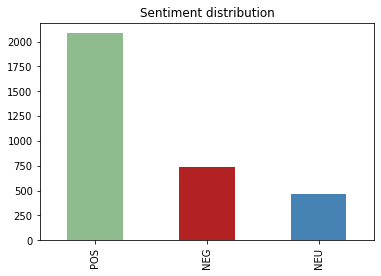

In [10]:
# plot proportion of positive, negative and neutral reviews
sentiment_counts = reviews['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red'], COLORS['blue']])
plt.title('Sentiment distribution')
plt.show()

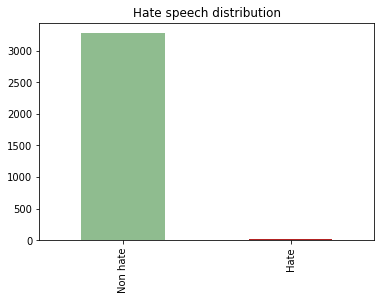

In [11]:
# plot proportion of hate speech and non hate speech reviews
hate_speech_counts = reviews['hate_speech'].apply(lambda x: len(x) > 0).value_counts()
hate_speech_counts.index = ['Non hate', 'Hate']
hate_speech_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red']])
plt.title('Hate speech distribution')
plt.show()

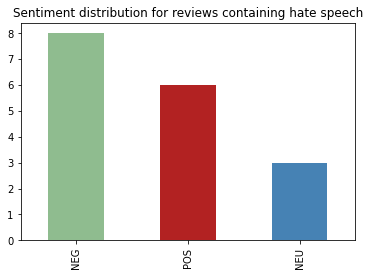

In [12]:
hate_speech_reviews = reviews[reviews['hate_speech'].apply(lambda x: len(x) > 0)]

# get the reviews that contain hate speech and plot the sentiment distribution
hate_speech_sentiment_counts = hate_speech_reviews['sentiment'].value_counts()
hate_speech_sentiment_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red'], COLORS['blue']])
plt.title('Sentiment distribution for reviews containing hate speech')
plt.show()

Text(0.5, 1.0, 'Sentiment distribution for positive reviews')

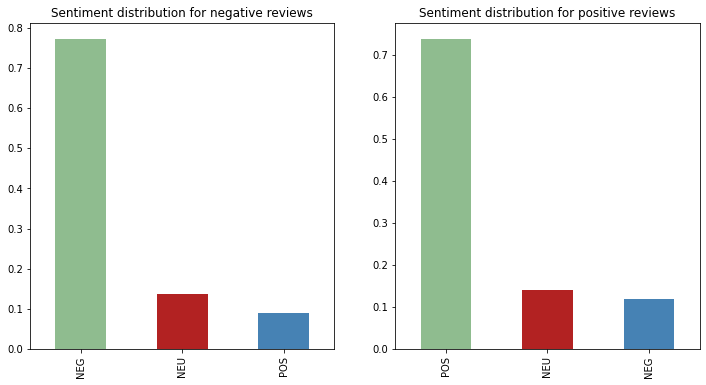

In [13]:
negative_reviews = reviews[reviews['review_score'] == -1]
positive_reviews = reviews[reviews['review_score'] == 1]

plt.figure(figsize=(12, 6))

# get the reviews that have negative review_score and plot the sentiment distribution for those
plt.subplot(1, 2, 1)
negative_sentiment_counts = negative_reviews['sentiment'].value_counts(normalize=True)
negative_sentiment_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red'], COLORS['blue']])
plt.title('Sentiment distribution for negative reviews')

# get the reviews that have positive review_score and plot the sentiment distribution for those
plt.subplot(1, 2, 2)
positive_sentiment_counts = positive_reviews['sentiment'].value_counts(normalize=True)
positive_sentiment_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red'], COLORS['blue']])
plt.title('Sentiment distribution for positive reviews')

Text(0.5, 1.0, 'Hate speech distribution for positive reviews')

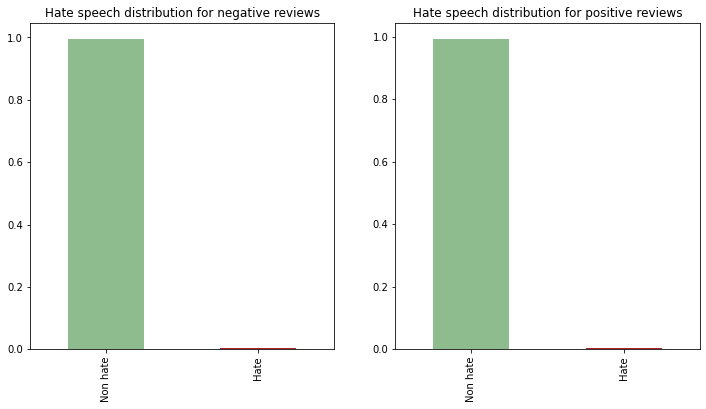

In [14]:
plt.figure(figsize=(12, 6))

# plot the hate speech distribution for negative reviews
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
negative_hate_speech_counts = negative_reviews['hate_speech'].apply(lambda x: len(x) > 0).value_counts(normalize=True)
negative_hate_speech_counts.index = ['Non hate', 'Hate']
negative_hate_speech_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red']])
plt.title('Hate speech distribution for negative reviews')

# plot the hate speech distribution for positive reviews
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
positive_hate_speech_counts = positive_reviews['hate_speech'].apply(lambda x: len(x) > 0).value_counts(normalize=True)
positive_hate_speech_counts.index = ['Non hate', 'Hate']
positive_hate_speech_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red']])
plt.title('Hate speech distribution for positive reviews')

#### Word analysis

In [15]:
# get the stop words to filter out 
stop_words = set(stopwords.words('english'))

100%|██████████| 3291/3291 [00:00<00:00, 4067.81it/s]


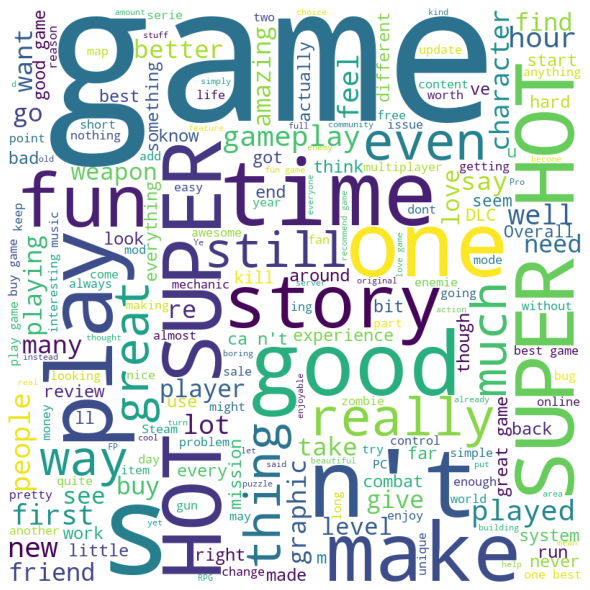

In [16]:
filter_word_cloud(reviews, stop_words)

100%|██████████| 17/17 [00:00<00:00, 2992.41it/s]


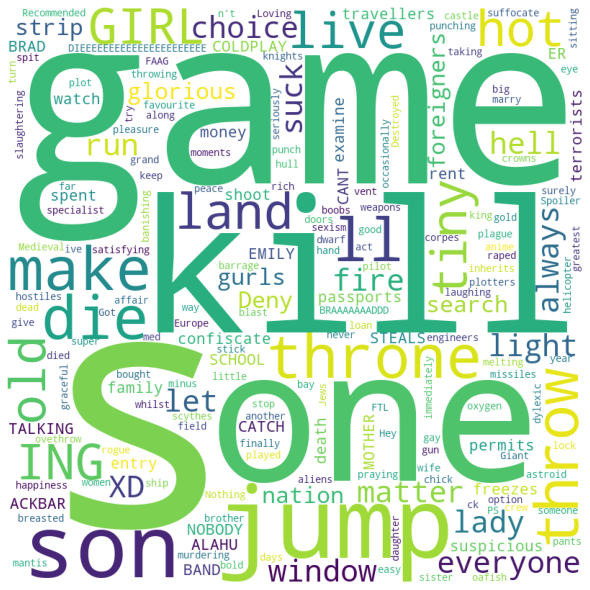

In [17]:
filter_word_cloud(hate_speech_reviews, stop_words)

100%|██████████| 2759/2759 [00:00<00:00, 4548.17it/s]


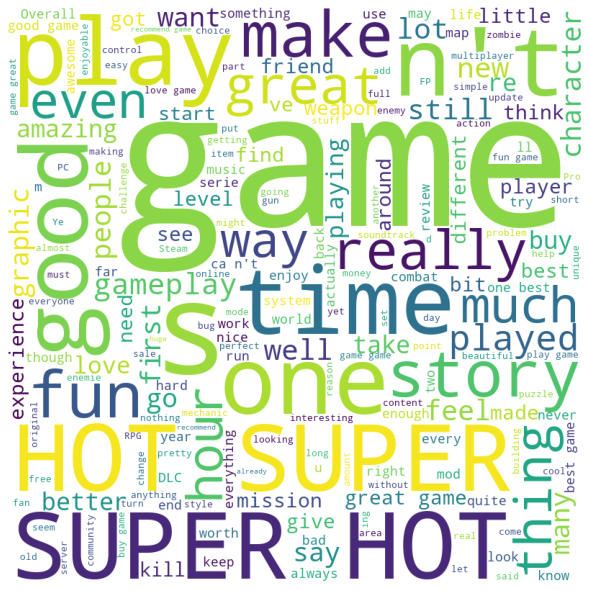

In [18]:
filter_word_cloud(positive_reviews, stop_words)

100%|██████████| 532/532 [00:00<00:00, 3333.44it/s]


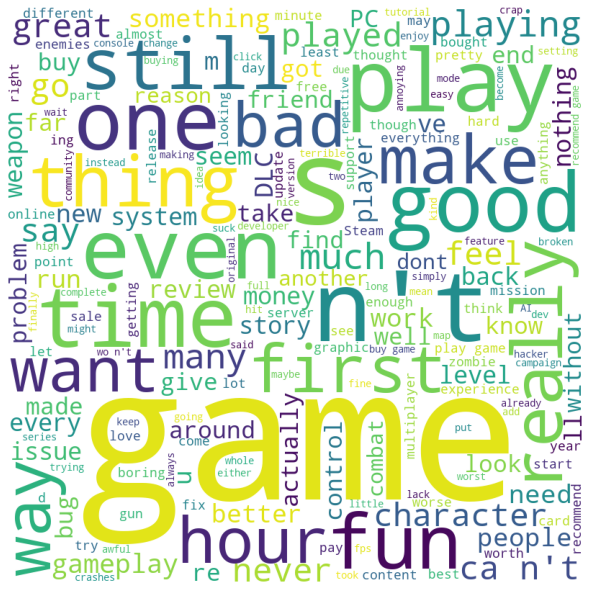

In [19]:
filter_word_cloud(negative_reviews, stop_words)